In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import py2neo

In [3]:
from py2neo import Graph

ip_virtual_wall = "193.191.169.38"
port = '7687'
user_pass_tup = ('neo4j', 'admin')
connect_string = "bolt://" + ip_virtual_wall + ":" + port

print(connect_string)


#graph = Graph("bolt://193.191.169.12:7687", auth=('neo4j', 'admin'))
graph = Graph(connect_string, auth=user_pass_tup)


graph.delete_all()

bolt://193.191.169.38:7687


### Debug hint: If your Neo4J container refuses to ingest your data just restart it with: sudo docker stop|start neo4j

# Exercise 3: Routeplanning in Ghent using public transport GTFS data of De Lijn

We are going to be working with <b>GTFS</b> data from De Lijn

1. Go the the jupyter start window and open a 'new > terminal'
2. Create a directory ./work/data and `cd` to it
3. Download and unzip the GTFS data of de lijn:
    - `wget https://transitfeeds.com/p/vlaamse-vervoersmaatschappij-de-lijn/530/latest/download`
    - `unzip download`
4. Have a look at the GTFS specification: 
    -  https://en.wikipedia.org/wiki/General_Transit_Feed_Specification

### 3a. Let's first read and explore our data which is in CSV format. Open the 'stops', 'trips', 'routes' and 'stoptimes' datasets, have a look at the top records. Plot the distribution of lat/lon coordinates for the stops.txt file


In [4]:
dataset_stops = pd.read_csv("data/stops.txt")
dataset_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,13142,304302,Rotselaar Heirbaan,NaN,50.959916,4.744196,NaN,NaN,NaN,NaN
1,13143,304303,Rotselaar Heirbaan,NaN,50.960401,4.744228,NaN,NaN,NaN,NaN
2,13144,304304,Rotselaar Schoolstraat,NaN,50.958759,4.737867,NaN,NaN,NaN,NaN
3,13145,304305,Rotselaar Schoolstraat,NaN,50.958929,4.738025,NaN,NaN,NaN,NaN
4,13146,304306,Rotselaar Dorp,NaN,50.949411,4.713672,NaN,NaN,NaN,NaN


In [5]:
dataset_trips = pd.read_csv("data/trips.txt")
dataset_trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id
0,50863,42923,32854636,Aarschot - Geel,NaN,0,NaN,NaN
1,50863,42926,32854637,Aarschot - Geel,NaN,0,NaN,NaN
2,50867,42925,32855341,Geel - Westerlo - Heist-op-den-Berg - Mechelen,NaN,1,NaN,NaN
3,50873,42922,32855820,Mechelen - Putte - Schriek - Tremelo,NaN,1,NaN,NaN
4,50873,42922,32855821,Mechelen - Putte - Schriek - Tremelo,NaN,1,NaN,NaN


In [6]:
dataset_routes = pd.read_csv("data/routes.txt")
dataset_routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,48938,1,1,Brugge Station-Centrum (Dijver) -Ver Assebroek,Brugge Station - Centrum (Dijver) - Ver-Assebr...,3,NaN,BB0022,FFFFFF
1,48939,1,2,Brugge 't Zand -Station-AZ St.Lucas-Assebroek,Assebroek Oude Stelplaats - Brugge Station/Bru...,3,NaN,BBDD00,000000
2,48940,1,3,Brugge Station-St.Pieters-Centrum(Stadsschouwb...,Sint-Pieters - Centrum/Brugge Station - Sint-P...,3,NaN,771133,FFFFFF
3,48941,1,4,Brugge Station-Centrum-St.Jozef-Koolkerke,Koolkerke - Brugge Centrum/Brugge Station - Ce...,3,NaN,0044BB,FFFFFF
4,48942,1,5,Brugge Centrum -Station-St.Andries (Hermitage),Sint-Andries Hermitage - Brugge Station/Brugge...,3,NaN,995511,FFFFFF


In [7]:
dataset_stoptimes = pd.read_csv("data/stop_times.txt")
dataset_stoptimes.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,32770162,16:43:00,16:43:00,126992,39,NaN,0,0,NaN
1,32770162,16:42:00,16:42:00,25727,38,NaN,0,0,NaN
2,32770162,16:40:00,16:40:00,98784,37,NaN,0,0,NaN
3,32770162,16:40:00,16:40:00,23801,36,NaN,0,0,NaN
4,32770162,16:38:00,16:38:00,109494,35,NaN,0,0,NaN


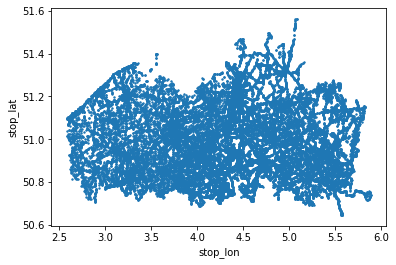

In [8]:
# make a scatter plot of the bus and tram stops of de lijn
dataset_stops.plot.scatter("stop_lon", "stop_lat", 2)

### 3b. To have a feel of the data and the relations study the GTFS description and try to retrieve all data related to the route going from Gentbrugge to the UZ

* HINT: It's useful to have a look at text handling in pandas: http://pandas.pydata.org/pandas-docs/stable/text.html


1. Find the route_ids of this trajectory

2. Filter the trips dataframe and have look at all the trips associated with this route

3. Choose 1 trip_id and have a have a look at the data associated with it in dataset_stoptimes

This should give you an idea how the different dataframes can be linked to each other

In [9]:
# 1
# select columns from stops
stops = dataset_stops[['stop_id', 'stop_name']]
# select rows from stops where stop name starts with 'Gentbrugge'
stops_gentbrugge = stops[(stops['stop_name'].astype(str).str[0:10 ] == 'Gentbrugge')][['stop_id']]
# select rows from stops where stop name starts with 'Gent UZ' or 'Gent Universitair Ziekenhuis'
stops_uz         = stops[(stops['stop_name'].astype(str).str[0:7 ] == 'Gent UZ') |
                         (stops['stop_name'].astype(str).str[0:28] == 'Gent Universitair Ziekenhuis')][['stop_id']]

# select distinct trip ids from these stops
trip_ids_gentbrugge = pd.merge(stops_gentbrugge, dataset_stoptimes[['stop_id', 'trip_id']], on='stop_id', how='inner')[['trip_id']]
print(len(trip_ids_gentbrugge))
trip_ids_uz         = pd.merge(stops_uz        , dataset_stoptimes[['stop_id', 'trip_id']], on='stop_id', how='inner')[['trip_id']]
print(len(trip_ids_uz))
trip_ids = pd.merge(trip_ids_gentbrugge, trip_ids_uz, on='trip_id', how='inner')
print(len(trip_ids))
# select distinct route ids form these trips
route_ids = pd.merge(trip_ids, dataset_trips[['trip_id', 'route_id']], on='trip_id', how='inner')[['route_id']].drop_duplicates()['route_id'].tolist()
print(len(route_ids))
print(route_ids)

20546
3355
125
3
[51898, 51899, 51900]


In [10]:
# 2
dataset_trips_filtered = dataset_trips[dataset_trips['route_id'].isin(route_ids)]
dataset_trips_filtered.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id
23553,51898,45205,33617092,Stelplaats - Ledeberg - Gent UZ,NaN,0,NaN,NaN
23554,51898,45205,33617093,Stelplaats - Ledeberg - Gent UZ,NaN,0,NaN,NaN
23555,51898,45205,33617094,Stelplaats - Ledeberg - Gent UZ,NaN,0,NaN,NaN
23556,51898,45205,33617095,Stelplaats - Ledeberg - Gent UZ,NaN,0,NaN,NaN
23557,51898,45205,33617096,Stelplaats - Ledeberg - Gent UZ,NaN,0,NaN,NaN


In [11]:
# 3
trip_id = 33617092
dataset_stoptimes_filtered = dataset_stoptimes[dataset_stoptimes['trip_id'] == trip_id]
dataset_stoptimes_filtered.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
3116832,33617092,5:57:00,5:57:00,120628,34,NaN,0,0,NaN
3116833,33617092,5:54:00,5:54:00,111425,31,NaN,0,0,NaN
3116834,33617092,5:53:00,5:53:00,111424,30,NaN,0,0,NaN
3116835,33617092,5:47:00,5:47:00,111182,27,NaN,0,0,NaN
3116836,33617092,5:49:00,5:49:00,111183,28,NaN,0,0,NaN


### 3c. For efficiency reasons we are going to focus on Ghent. We are going to remove all data which is not related to Gent 

1. Filter the stops to be in the bounding box given below in the comments: (http://www.gps-coordinates.net/)
2. Verify if you made a correct selection by making a scatter plot of both the original and the filtered frame, does this correspond to Gent?

3. Get all trip_ids with at least 1 stop in Ghent (use dataset_stoptimes)
4. In fact we only need one trip per (route, direction) to create the graph on the Ghent network => limit the number of trips + filter the dataset_stoptimes accordingly

5. Create nodes and edges and import into the Neo4J database (make sure the data of the previous notebook is erased first)

    - The nodes should have properties with the stop_id, stop_name, the geocoordinates and a label 'DL'
    - The edges must containt the trip_id, trip_headsign and the traveltime for this specific edge and a label 'CONNECTION'
    - CAUTION: make that only unique nodes are ingested (stops may be occur in multiple trips!)



In [12]:
# Links:   Latitude: 51.042948 | Longitude: 3.606262
# Rechts:  Latitude: 51.055035 | Longitude: 3.810883
# Boven:   Latitude: 51.100762 | Longitude: 3.717499
# Onder:   Latitude: 50.990248 | Longitude: 3.729858

# 1
stops_ghent = dataset_stops[
    (3.606262 <= dataset_stops['stop_lon']) &
    (dataset_stops['stop_lon'] <= 3.810883) &
    (50.990248 <= dataset_stops['stop_lat']) &
    (dataset_stops['stop_lat'] <= 51.100762)
]


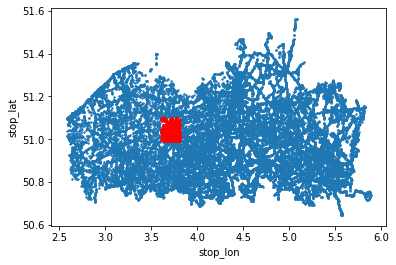

In [13]:
# 2
fig, ax = plt.subplots()
dataset_stops.plot.scatter("stop_lon", "stop_lat", 2,ax=ax)
stops_ghent.plot.scatter("stop_lon", "stop_lat", 2, 'red',ax=ax)

In [14]:
# 3
trips_ghent = pd.merge(stops_ghent['stop_id'], dataset_stoptimes[['stop_id', 'trip_id']], on='stop_id', how='inner')[['trip_id']]
#print("The amout of trips passing through Gent: " + str(len(trips_ghent)))
trips_ghent_unique = trips_ghent.drop_duplicates() #only unique tripids
print("The amout of trips passing through Gent: " +  str(len(trips_ghent_unique)))

The amout of trips passing through Gent: 16028


In [15]:
# 4
#find 1 trip per unique (route,direction) combination
routes_ghent = dataset_trips[dataset_trips['trip_id'].isin(trips_ghent_unique['trip_id'])][['trip_id', 'route_id', 'direction_id','trip_headsign']]
trips_ghent_unique_routes = routes_ghent.groupby(['route_id','direction_id'],as_index=False).first()[['trip_id','trip_headsign']]
print(trips_ghent_unique_routes.head())
print("The amount of filtered trips is " + str(len(trips_ghent_unique_routes)))

#trips_ghent_unique = dataset_trips[dataset_trips['trip_id'].isin(trips_ghent.drop_duplicates()['trip_id'].tolist())]
#print(trips_ghent_unique.shape)

    trip_id                                      trip_headsign
0  33252039                       Sint-Pieters - Arteveldepark
1  33252040  Arteveldepark - Sint-Pieters - K. Fabiolalaan ...
2  33618380                    Gent Flanders Expo - Korenmarkt
3  33617069  Gentbrugge Stelplaats - Gent Korenmarkt - Evergem
4  33617073  Evergem - Gent Korenmarkt - Gentbrugge Stelplaats
The amount of filtered trips is 152


In [16]:
#filter dataset_stoptimes accordingly
stoptimes_ghent = pd.merge(trips_ghent_unique_routes, dataset_stoptimes, on='trip_id', how = 'inner')
stoptimes_ghent.head()
#stoptimes_ghent = pd.merge(trips_ghent_unique, dataset_stoptimes, on='trip_id', how='inner')

,trip_id,trip_headsign,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,33252039,Sint-Pieters - Arteveldepark,6:47:00,6:47:00,129097,7,NaN,0,0,NaN
1,33252039,Sint-Pieters - Arteveldepark,6:45:00,6:45:00,125169,6,NaN,0,0,NaN
2,33252039,Sint-Pieters - Arteveldepark,6:49:00,6:49:00,127587,8,NaN,0,0,NaN
3,33252039,Sint-Pieters - Arteveldepark,6:43:00,6:43:00,125413,5,NaN,0,0,NaN
4,33252039,Sint-Pieters - Arteveldepark,6:40:00,6:40:00,111150,3,NaN,0,0,NaN


In [17]:
from py2neo import Node
from py2neo import Relationship
from py2neo import Subgraph

ip_virtual_wall = "193.191.169.38"
user = 'neo4j'
user_pass_tup = ('neo4j', 'admin')
port = '7687'

# set up authentication parameters
connect_string = "bolt://" + ip_virtual_wall + ":" + port

# connect to authenticated graph database
graph = Graph(connect_string, auth=user_pass_tup)
print(graph)

# reset the graph
graph.delete_all()

<Graph database=<Database uri='bolt://193.191.169.38:7687' secure=False user_agent='py2neo/4.3.0 neobolt/1.7.16 Python/3.7.6-final-0 (linux)'> name='data'>


In [18]:
# 5a Add unique stops
# only stops in Ghent
nodes = []
for _, stop in stops_ghent[['stop_id', 'stop_name', 'stop_lon', 'stop_lat']].drop_duplicates().iterrows():
    nodes.append(Node("DL", stop_id=stop.stop_id, stop_name=stop.stop_name, stop_lon=stop.stop_lon, stop_lat=stop.stop_lat))

for node in nodes:
    graph.create(node)
print(graph)

<Graph database=<Database uri='bolt://193.191.169.38:7687' secure=False user_agent='py2neo/4.3.0 neobolt/1.7.16 Python/3.7.6-final-0 (linux)'> name='data'>


In [19]:
# 5b Add edges and calculate travel time
def traveltime(start, stop):
    hours = int(stop.split(':')[0]) -  int(start.split(':')[0])
    minutes = int(stop.split(':')[1]) -  int(start.split(':')[1])

    return 60*hours+minutes


In [20]:
trips_ghent_unique = trips_ghent_unique_routes
print(trips_ghent_unique)
print(stoptimes_ghent)

matcher = py2neo.NodeMatcher(graph)
edges = []

for _, trip in trips_ghent_unique.iterrows():
    for _, stop in stoptimes_ghent.iterrows():
        if stop.trip_id == trip.trip_id:
            # get stop1 from stops using stoptimes
            stop1 = stop
            
            # get stop2 from stops using stoptimes.stop_sequence + 1 if it exists
            stop2 = stoptimes_ghent[(stoptimes_ghent['trip_id']==stop.trip_id) & (stoptimes_ghent['stop_sequence']==stop.stop_sequence+1)]
            
            # add edges
            if (not stop2.empty):
                time = traveltime(stop1.departure_time, stop2.arrival_time.tolist()[0])
                #get nodes for stop1, stop2
                node1 = matcher.match("DL", stop_id=stop1.stop_id).first()
                node2 = matcher.match("DL", stop_id=stop2.stop_id.tolist()[0]).first()
                if (node1==None or node2==None): #stop not in Ghent, but route goes through ghent
                    #print("node not found")
                    pass
                else:
                    edges.append(Relationship(node1, "CONNECTION", node2, trip_id=trip.trip_id, trip_headsign=trip.trip_headsign, traveltime=time))

print(edges[0:5])       
   

      trip_id                                      trip_headsign
0    33252039                       Sint-Pieters - Arteveldepark
1    33252040  Arteveldepark - Sint-Pieters - K. Fabiolalaan ...
2    33618380                    Gent Flanders Expo - Korenmarkt
3    33617069  Gentbrugge Stelplaats - Gent Korenmarkt - Evergem
4    33617073  Evergem - Gent Korenmarkt - Gentbrugge Stelplaats
..        ...                                                ...
147  33817896                                Gent UZ - Gent Zuid
148  33822915               Gent Dampoort - Drongen Drongenplein
149  33822914                   Gent Brugsepoort - P+R Oostakker
150  33822938                 Gent Sint-Pieters - Oostakker Dorp
151  33822940           Gent Dampoort - Sint-Denijs-Westrem Dorp

[152 rows x 2 columns]
       trip_id                             trip_headsign arrival_time  \
0     33252039              Sint-Pieters - Arteveldepark      6:47:00   
1     33252039              Sint-Pieters - Artevel

In [21]:
# ingest all nodes and edges (NOTE: using a Subgraph may lead to errors, a workaround is to ingest the edges on at a time)
#nodes already done
for edge in edges:
    graph.create(edge)
    
    
print("The number of nodes is: " + str(len(graph.nodes)))
print("The number of relationships is: " + str(len(graph.relationships)))

The number of nodes is: 1394
The number of relationships is: 1179


* How many nodes and edges have been created?

In [22]:
query = """
MATCH (n:DL)
RETURN COUNT(n)
"""
print(graph.run(query).data())

query = """
MATCH ()-[r:CONNECTION]->()
RETURN COUNT(r)
"""
print(graph.run(query).data())

[{'COUNT(n)': 1394}]
[{'COUNT(r)': 1179}]


### 3d We want to connect all stops which are at approximately the same location. 

1. Create and ingest a set of edges of the type :CHANGE with time:1
2. check how :CHANGE edges many have been created 
3. check if Gent Sint Pieters is connected to the nearby stops you'd expect, use node with stop_name: 'Gent Sint-Pietersstation perron 1' to verify

In [23]:
query = """
MATCH (n)-[r:CONNECTION]->(m)
WHERE r.traveltime = 1
CREATE p = (n)-[:CHANGE]->(m)
RETURN p 
"""
pd.DataFrame(graph.run(query).data())

,p
0,({})
1,({})
2,({})
3,({})
4,({})
...,...
769,({})
770,({})
771,({})
772,({})


In [24]:
query = """
MATCH ()-[r:CHANGE]->()
RETURN COUNT(r)
"""
pd.DataFrame(graph.run(query).data())

,COUNT(r)
0,774


In [25]:
query= """
MATCH (n{stop_name:'Gent Sint-Pietersstation perron 1'})-[:CHANGE]->(m)
RETURN m.stop_name
"""
print(pd.DataFrame(graph.run(query).data()))
#no edges found -> Gent Sint-Pietersstation perron 1 is close to perron 2, but there will never be a bus/tram going from 1 to 2

query= """
MATCH (n{stop_name:'Gent Sint-Pietersstation perron 1'})-[:CONNECTION]->(m)
RETURN m.stop_name
"""
pd.DataFrame(graph.run(query).data())
# 1 stop found: "Gent Hogeschool Gent"

Empty DataFrame
Columns: []
Index: []


,m.stop_name
0,Gent Hogeschool Gent


# 4. Route planning: I want to find the optimal path 

* From a set of geocoordinates in Ghent
* To the geocoordinates of Vooruit Cafe in Ghent



### 4a. Stops within walking distance

You can use the <span style="color:red; font-weight:bold;"> HAVERSIN </span>function used to calculate distances <b>|AB|</b> along a sphere:

`2 * 6371 * asin(sqrt(haversin(radians(`<b>A</b>`.lat - `<b>B</b>`.lat)) +` `cos(radians(`<b>A</b>`.lat)) * cos(radians(`<b>B</b>`.lat)) * haversin(radians(`<b>A</b>`.lon - `<b>B</b>`.lon))))`

* Write a function which returns all nodes which are within walking distance (for example 0.5 km) of a certain set of coordinates
* Verify for two locations (the ones you'll be using for the route planning). 


In [26]:
def allNodesDinstancesNearby(lat, lon, maxDist):
    query = """
    MATCH (n:DL)
    WHERE (2 * 6371 * asin(sqrt(haversin(radians(""" + str(lat) + """ - n.stop_lat)) + cos(radians(""" + str(lat) + """)) * cos(radians(n.stop_lat)) * haversin(radians(""" + str(lon) + """ -n.stop_lon)))))<=""" + str(maxDist) + """
    RETURN n.stop_name, n.stop_id, n.stop_lat, n.stop_lon
    """
    #nearbyNodes= pd.DataFrame(graph.run(query).data())
    return graph.run(query).data()

# We tested with Strop <> Vooruit, we pick nearby locations as the path queries are quite heavy 
# and Neo4J doesn't have a lot of memory

vooruit_lat=51.0477
vooruit_lon=3.7275

strop_lat = 51.034809
strop_lon = 3.729268

In [27]:
nearStrop = allNodesDinstancesNearby(strop_lat, strop_lon,0.5)
pd.DataFrame(nearStrop)

,n.stop_name,n.stop_id,n.stop_lat,n.stop_lon
0,Gent Terplatenbrug,111369,51.038643,3.730551
1,Gent Heuvelpoort,111370,51.038611,3.726473
2,Gent De Heerestraat,111454,51.034291,3.725506
3,Gent Burggravenlaan,111455,51.032321,3.723523
4,Gent Zomerstraat,111614,51.031551,3.729179
5,Gent Terplatenbrug,112289,51.039025,3.731529
6,Gent Heuvelpoort,112290,51.038187,3.726137
7,Gent Zuiderpoort,112345,51.035812,3.735708
8,Gent De Heerestraat,112370,51.034635,3.725815
9,Gent Ottergemsesteenweg,112378,51.037012,3.726595


In [28]:
nearVooruit = allNodesDinstancesNearby(vooruit_lat, vooruit_lon,0.5)
pd.DataFrame(nearVooruit)

,n.stop_name,n.stop_id,n.stop_lat,n.stop_lon
0,Gent Zuid perron 1,126533,51.048213,3.731618
1,Gent Zuid perron 5,126534,51.047870,3.731366
2,Gent Zuid perron 4,126547,51.047933,3.731437
3,Gent Zuid perron 9,126551,51.048226,3.730791
4,Gent Zuid perron 1,126569,51.048213,3.731618
5,Gent Zuid perron 2,126574,51.048069,3.731549
6,Gent Zuid perron 7,126575,51.047503,3.731599
7,Gent Zuid perron 3,126588,51.048033,3.731549
8,Gent Zuid perron 8,126591,51.048218,3.730991
9,Gent Zuid perron 6,126651,51.047530,3.731699


### 4b Finding a path between two nodes

* Write a query to find a path between two stops, choose stops which could be used in your path algorithm
* **NOTE** this are typically heavy queriest, gradually increase the maximum path length and don't choose your stops to far apart (max pathlength 6 should be fine)

* Your dataframe should contain the stop names and the path length in terms of stops

In [29]:
#length in terms of stops -> excluding first stop
maxPath = 2
answer = pd.DataFrame()

while answer.empty:
    maxPath += 1
    query = """
    MATCH p = (:DL{stop_name:'Zwijnaarde Remi Vlerickstraat'})-[r:CONNECTION *1.."""+ str(maxPath) + """]->(:DL{stop_name:'Zwijnaarde Heerweg Zuid'})
    WITH reduce(l = [], n IN nodes(p)| l + n.stop_name) as stops, length(p) as length
    RETURN stops, length
    """
    answer = pd.DataFrame(graph.run(query).data())

print(answer)

                                               stops  length
0  [Zwijnaarde Remi Vlerickstraat, Zwijnaarde Zan...       3


### 4c Extract the travel time per path

*Write a query which returns the travel time for each path  and return the 10 shortest travel_times. 


In [30]:
#for each path from somewhere near Strop to somewhere near Vooruit
query = """
MATCH p = (n:DL)-[r:CONNECTION *0..10]->(m:DL)
WHERE n.stop_id IN """ + str(pd.DataFrame(nearStrop)['n.stop_id'].tolist()) + """ AND  m.stop_id IN """ + str(pd.DataFrame(nearVooruit)['n.stop_id'].tolist()) +"""
WITH reduce(l = [], node IN nodes(p)| l + node.stop_name) as stops, reduce(sum = 0, c IN relationships(p)| sum + c.traveltime) as travel_time,
    n.stop_name AS start, m.stop_name AS destination
ORDER BY travel_time
LIMIT 10
return stops, start, destination, travel_time
"""
pd.DataFrame(graph.run(query).data())

,stops,start,destination,travel_time
0,"[Gent Terplatenbrug, Gent Leeuwstraat, Gent Mu...",Gent Terplatenbrug,Gent Zuid perron 3,4
1,"[Gent Terplatenbrug, Gent Leeuwstraat, Gent Mu...",Gent Terplatenbrug,Gent Zuid perron 5,4
2,"[Gent Ottergemsesteenweg, Gent Heuvelpoort, Ge...",Gent Ottergemsesteenweg,Gent Blandijnberg,4
3,"[Gent Ottergemsesteenweg, Gent Heuvelpoort, Ge...",Gent Ottergemsesteenweg,Gent Bagattenstraat,5
4,"[Gent Terplatenbrug, Gent Leeuwstraat, Gent Mu...",Gent Terplatenbrug,Gent Zuid perron 1,5
5,"[Gent Heuvelpoort, Gent Terplatenbrug, Gent Le...",Gent Heuvelpoort,Gent Zuid perron 3,5
6,"[Gent De Heerestraat, Gent Ottergemsesteenweg,...",Gent De Heerestraat,Gent Blandijnberg,5
7,"[Gent Heuvelpoort, Gent Terplatenbrug, Gent Le...",Gent Heuvelpoort,Gent Zuid perron 5,5
8,"[Gent Terplatenbrug, Gent Leeuwstraat, Gent Mu...",Gent Terplatenbrug,Gent Lippensplein,6
9,"[Gent Heuvelpoort, Gent Terplatenbrug, Gent Le...",Gent Heuvelpoort,Gent Zuid perron 1,6


### 4d Connect everything together. Find the shortest path for the chosen location to Gent Vooruitcafe. Make sure all the travel details are nicely shown in the dataframe

* HINT: In the shortest path statement limit the maximum path length, otherwise the query will return an error
* => `p = shortestPath( (m)-[*0..5]->(n)) `
* NOTE: there will be multiple results as there are multiple start en stop locations => expect <=1 result per combination of start and stop 


In [31]:
query = """
MATCH p = shortestPath((n:DL)-[r:CONNECTION *0..10]->(m:DL))
WHERE n.stop_id IN """ + str(pd.DataFrame(nearStrop)['n.stop_id'].tolist()) + """ AND  m.stop_id IN """ + str(pd.DataFrame(nearVooruit)['n.stop_id'].tolist()) +"""
WITH reduce(l=[], node IN nodes(p) | l+node.stop_name) AS stops, reduce(sum = 0, c IN relationships(p)| sum + c.traveltime) as travel_time, 
         n.stop_name AS start, m.stop_name AS destination
ORDER BY travel_time
RETURN stops, start, destination, travel_time
"""
pd.DataFrame(graph.run(query).data()).head(1)

,stops,start,destination,travel_time
0,"[Gent Terplatenbrug, Gent Leeuwstraat, Gent Mu...",Gent Terplatenbrug,Gent Zuid perron 5,4
